# Probabilistic-Matrix-Factorization

- [Repositorio](https://github.com/fuhailin/Probabilistic-Matrix-Factorization/tree/master)

- [Paper](https://proceedings.neurips.cc/paper_files/paper/2007/hash/d7322ed717dedf1eb4e6e52a37ea7bcd-Abstract.html)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split
import nbformat as nbf
import pathlib, os

## 1. Cargar BD 'u.data'

    Unicamente devuelve las columnas user_id, item_id, rating

In [ ]:
u_data = "data/u.data"

def load_rating_data(u_data_path: pathlib.Path) -> np.ndarray:
    data = np.loadtxt(u_data_path, dtype=np.int64)
    # userId, itemId empiezan en 1 -> pasamos a base-0
    data[:, 0] -= 1
    data[:, 1] -= 1
    # Solamente queremos quedarnos con las columnas: user, item, rating (ignoramos timestamp)
    return data[:, :3].astype(np.float64)

ratings = load_rating_data(u_data)
n_users = int(ratings[:, 0].max()) + 1
n_items = int(ratings[:, 1].max()) + 1

print(f"Ratings: {ratings.shape}, usuarios={n_users}, items={n_items}")

Ratings: (100000, 3), usuarios=943, items=1682


## 2. Train /test

    Dividir el dataset en train (80%) y test(20%)

In [10]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
print("Train:", train.shape, "Test:", test.shape)

Train: (80000, 3) Test: (20000, 3)


## 3. Definir PMF

    (La Clase PMF es igual que la del repositorio)

In [12]:
# -*- coding: utf-8 -*-
import numpy as np


class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # 评分平均值

        pairs_train = train_vec.shape[0]  # traindata 中条目数
        pairs_test = test_vec.shape[0]  # testdata中条目数

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # 第0列，user总数
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # 第1列，movie总数

        incremental = False  # 增量
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn 电影 M x D 正态分布矩阵
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn 用户 N x D 正态分布矩阵

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  # 创建电影 M x D 0矩阵
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # 创建用户 N x D 0矩阵

        while self.epoch < self.maxepoch:  # 检查迭代次数
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # 根据记录数创建等差array
            np.random.shuffle(shuffled_order)  # 用于将一个列表中的元素打乱

            # Batch update
            for batch in range(self.num_batches):  # 每次迭代要使用的数据量
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # 本次迭代要使用的索引下标

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply对应位置元素相乘

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort索引排序

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)

## 4. Definir modelo PMF

    Mismos parámetros de entrada que en el repo

In [ ]:
pmf = PMF()
pmf.set_params({
    "num_feat": 10,
    "epsilon": 1.0,
    "_lambda": 0.1,
    "momentum": 0.8,
    "maxepoch": 10,     # en el código tienen 10 pero luego en el README 100
    "num_batches": 100,
    "batch_size": 1000,
})

### Entrenar modelo

In [16]:
pmf.fit(train, test)

Training RMSE: 1.124155, Test RMSE 1.124645
Training RMSE: 1.121926, Test RMSE 1.124443
Training RMSE: 1.118671, Test RMSE 1.123522
Training RMSE: 1.111674, Test RMSE 1.119940
Training RMSE: 1.093707, Test RMSE 1.107802
Training RMSE: 1.053718, Test RMSE 1.077787
Training RMSE: 1.000739, Test RMSE 1.037679
Training RMSE: 0.955619, Test RMSE 1.004760
Training RMSE: 0.922450, Test RMSE 0.981571
Training RMSE: 0.898688, Test RMSE 0.966911


### Visualizar 


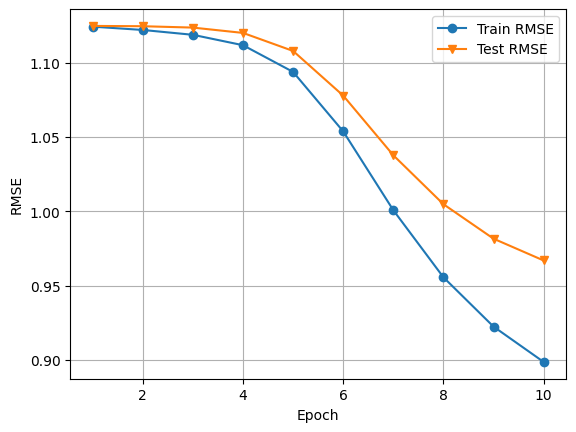

In [17]:
plt.plot(range(1, len(pmf.rmse_train)+1), pmf.rmse_train, marker='o', label='Train RMSE')
plt.plot(range(1, len(pmf.rmse_test)+1), pmf.rmse_test, marker='v', label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

### Evaluar 

In [18]:
prec, rec = pmf.topK(test, k=10)
print(f"Top-10 Precision: {prec:.4f}, Recall: {rec:.4f}")

Top-10 Precision: 0.0681, Recall: 0.0390


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split

import nbformat as nbf
import pathlib, os